# Decadal variablility of GMM in PCA space on reanalysis datasets

In [1]:
import os
from importlib import reload
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../../paper.mplstyle")

In [2]:
# Load weights
weight_month_mean = xr.open_dataset(
    "../../output/pcgmm/lens/lens_month_weights.nc"
)['p_c_given_x']
gmm_order = weight_month_mean.attrs['gmm_sort']

# Get Nino3.4 index 

In [3]:
path = "../../data/cmip6/historical/CESM2"

ds_list, members = [], []
for folder_name in os.listdir(path)[:20]:
    full_path = os.path.join(path, folder_name)
    if os.path.isdir(full_path):
        print(f'Load data in folder: {folder_name}')
        forcing, inityear, member = folder_name.split("_")
        fname = os.path.join(full_path, f'b.e21.BHIST{forcing}.f09_g17.LE2-{inityear}.{member}.ssta_lat-31_33_lon130_290_gr1.0.nc')
        buff = xr.open_dataset(fname)
        ds_list.append(buff)
        members.append(folder_name)

print("Merge members!")
ds = xr.concat(ds_list, dim=pd.Index(members, name='member'))
ds['lon'] = preproc.get_antimeridian_coord(preproc.lon_to_180(ds['lon']))

Load data in folder: smbb_1301_014
Load data in folder: cmip6_1281_005
Load data in folder: smbb_1231_017
Load data in folder: cmip6_1251_004
Load data in folder: cmip6_1181_010
Load data in folder: cmip6_1251_006
Load data in folder: cmip6_1251_007
Load data in folder: cmip6_1301_004
Load data in folder: smbb_1281_017
Load data in folder: smbb_1251_016
Load data in folder: smbb_1301_020
Load data in folder: smbb_1281_014
Load data in folder: cmip6_1281_004
Load data in folder: smbb_1071_004
Load data in folder: cmip6_1101_006
Load data in folder: smbb_1231_015
Load data in folder: cmip6_1231_003
Load data in folder: cmip6_1231_009
Load data in folder: smbb_1301_017
Load data in folder: smbb_1231_014
Merge members!


In [4]:
nino_indices = utenso.get_nino_indices(ds['ssta'], antimeridian=True)
nino_indices['time'] = np.array(nino_indices['time'].data, dtype='datetime64[M]') 

/tmp/ipykernel_21184/706055626.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  nino_indices['time'] = np.array(nino_indices['time'].data, dtype='datetime64[M]')
/tmp/ipykernel_21184/706055626.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silence

Monthly weighting of Nino3.4:

In [5]:
member = np.unique(weight_month_mean['member'])[5]
weights = weight_month_mean.where(weight_month_mean['member']==member, drop=True)
nino34 = nino_indices['nino34'].sel(member=member)
# Make sure weights and nino-indices are on the same time points
tmax = nino34['time'].max() if nino34['time'].max() < weights['time'].max() else weights['time'].max()
tmin = nino34['time'].min() if nino34['time'].min() > weights['time'].min() else weights['time'].min()
nino34 = nino34.sel(time=slice(tmin.data, tmax.data)).rolling(time=3, center=True).mean()
weights = weights.sel(time=slice(tmin.data, tmax.data))

nino34 = nino34.sel(time=weights['time'])

array([<Axes: ylabel='Nino3.4'>, <Axes: xlabel='density'>], dtype=object)

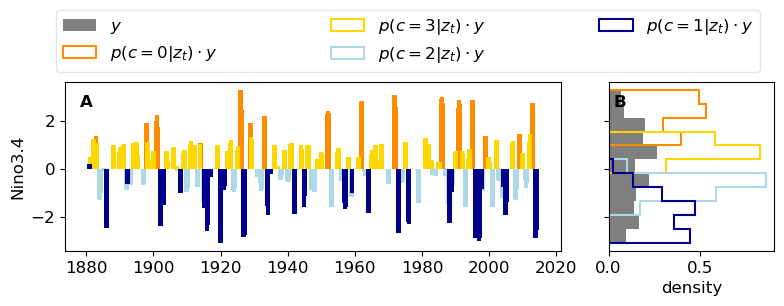

In [6]:
gmclrs = ['darkorange', 'gold', 'lightblue', 'darkblue', 'black']
fig, axs = plt.subplots(1, 2, 
                        width_ratios=[3,1],
                        figsize=(8, 2.5),
                        sharey=True)
#axs[0].bar(nino34['time'].data, height=nino34.data, width=4e2, label=rf'y', color='k')
im, bins, _ = axs[1].hist(nino34.data, bins='auto', density=True, orientation='horizontal',
                          histtype='bar', color='k', alpha=.5, label=rf'$y$')
for i, k in enumerate(gmm_order):
    n34_k = nino34 * weights.sel(classes=k+1)
    idx_nonzero = np.where(weights.sel(classes=k+1).data > 0.55)[0]
    n34_k = n34_k[idx_nonzero]
    axs[0].bar(n34_k['time'].data, height=n34_k.data, width=5e2,
                   color=gmclrs[i])#, label=rf'$p(c={k}|z_t) \cdot y$')
    axs[1].hist(n34_k.data, bins=bins, density=True, orientation='horizontal',
                histtype='step', color=gmclrs[i], linewidth=1.5, #alpha=.4,
                label=rf'$p(c={k}|z_t) \cdot y$')

axs[0].set_ylabel(f'$p_i \cdot y$')
axs[0].set_ylabel("Nino3.4")
axs[1].set_xlabel("density")
#axs[1].legend(bbox_to_anchor=(1., .1, .6, 1.), loc="lower left", ncol=1)
fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.07, 1.15, .9, 0.1), mode='expand')
gpl.enumerate_subplots(axs, pos_x=0.03, pos_y=.85, fontsize=12)

### Decadal variability

In [7]:
def rolling_window_covariance(da: xr.DataArray, window_size: int):
    covs = []
    times = []
    for i in range(window_size-1, len(da['time'])):
        # Select window
        chunk = da.isel(time=slice(i-window_size+1, i+1))
        # Compute covariance
        cov = np.cov(chunk.data)
        covs.append(cov)
        times.append(chunk.isel(time=int(window_size/2))['time'].data)
    
    return np.array(covs), np.array(times)



# Weighted Nino3.4
nino34_k = []
for k in weights['classes']:
    nino34_k.append(nino34 * weights.sel(classes=k))
nino34_k = xr.concat(nino34_k, dim=pd.Index(weights['classes'].data, name='classes'))

# Rolling mean variance over n_years
n_years = 20
nino34_var, times = rolling_window_covariance(nino34, window_size=3*n_years)
nino34_var = xr.DataArray(nino34_var, coords=dict(time=times))
nino34_k_cov, times = rolling_window_covariance(nino34_k, window_size=3*n_years)
nino34_k_cov = xr.DataArray(nino34_k_cov, coords=dict(time=times, c1=nino34_k['classes'].data, c2=nino34_k['classes'].data))

# Sum of covariances
n_times, n_features, _ = nino34_k_cov.shape
sum_covariances = np.zeros(n_times)
for i in range(n_features):
    for j in range(i+1, n_features):
        sum_covariances += nino34_k_cov.data[:, i, j]
nino34_k_cov_sum = xr.DataArray(2*sum_covariances, coords=dict(time=nino34_k_cov['time'].data))

In [8]:
# Stack plot every 10 years
n_step = 10
# Time points
year_arr = np.arange(np.array(nino34_k_cov['time'].min().data, dtype='datetime64[Y]'),
                     np.array(nino34_k_cov['time'].max().data, dtype='datetime64[Y]') + np.timedelta64(2, 'Y'),
                     step=n_step, dtype='datetime64[Y]')
time_arr = np.array([f"{y}-01-01" for y in year_arr], dtype='datetime64[D]')
# Select time points and stack plots
stacked_lines = [(nino34_k_cov.sel(time=time_arr, method='nearest').isel(c1=k, c2=k) / nino34_var
                  ) for k in gmm_order]
stacked_lines.append(
    nino34_k_cov_sum.sel(time=time_arr, method='nearest') / nino34_var
)

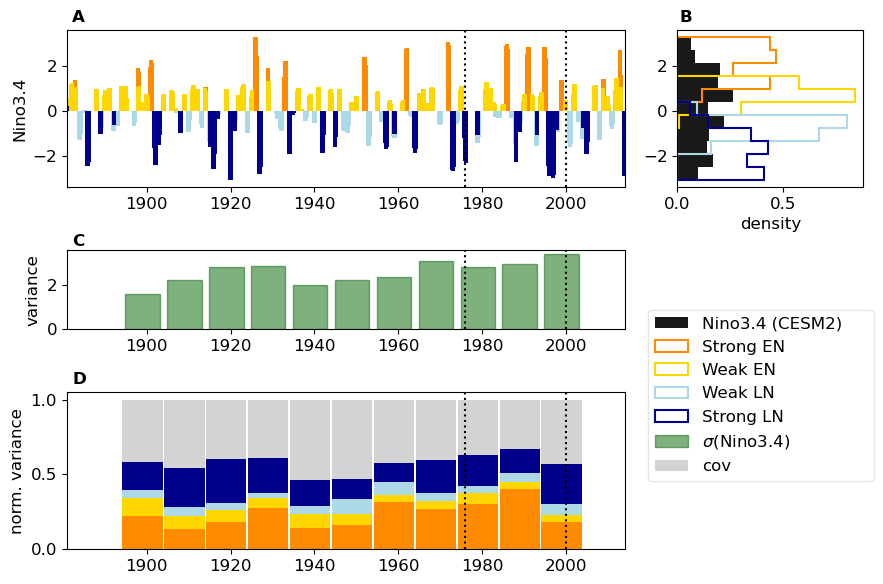

In [9]:
import matplotlib.gridspec as gridspec
class_names = ['Strong EN', 'Weak EN', 'Weak LN', 'Strong LN',]
clrs = gmclrs[:len(gmm_order)]
clrs.append('lightgrey')
labels = [rf"k={k}" for k in gmm_order]
labels.append("cov")
nrows, ncols = (3, 2)
fig = plt.figure(figsize=(9, nrows*2.))
gs = gridspec.GridSpec(nrows, ncols, width_ratios=[3,1], height_ratios=[2,1,2])
axs = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])]
axs.append(fig.add_subplot(gs[1,0], sharex=axs[0]))
axs.append(fig.add_subplot(gs[2,0], sharex=axs[0]))
axs.append(fig.add_subplot(gs[1:,1]))

# Nino34 time-series and hisplot
im, bins, _ = axs[1].hist(nino34.data, bins='auto', density=True, orientation='horizontal',
                          histtype='bar', color='k', alpha=.9, label=f'Nino3.4 (CESM2)')
for i, k in enumerate(gmm_order):
    n34_k = nino34 * weights.sel(classes=k+1)
    idx_nonzero = np.where(weights.sel(classes=k+1).data > 0.5)[0]
    n34_k = n34_k[idx_nonzero]
    axs[0].bar(n34_k['time'].data, height=n34_k.data, width=4e2,
                   color=gmclrs[i])
    axs[1].hist(n34_k.data, bins=bins, density=True, orientation='horizontal',
                histtype='step', color=gmclrs[i], linewidth=1.5, #alpha=.4,
                label=class_names[i])
#                label=r'$p(c_{k}|z_t) \cdot y$'.replace('k', str(k+1)))
axs[0].set_xlim(np.min(n34_k['time']).data, np.max(n34_k['time']).data)
axs[0].set_ylabel("Nino3.4")
axs[0].axvline(np.datetime64('1976-01-01'), ls=':', color='k')
axs[0].axvline(np.datetime64('2000-01-01'), ls=':', color='k')

axs[1].set_xlabel(r"density")

# Variance of Nino34
variance = nino34_var.sel(time=time_arr, method='nearest')
axs[2].bar(time_arr, height=variance, width=3e3, color='darkgreen', edgecolor='darkgreen', alpha=.5, 
           label=r'$\sigma$(Nino3.4)')
axs[2].set_ylabel(r"variance")
axs[2].axvline(np.datetime64('1976-01-01'), ls=':', color='k')
axs[2].axvline(np.datetime64('2000-01-01'), ls=':', color='k')

# Decadel variability
bottom = np.zeros_like(stacked_lines[0])
for i, stack in enumerate(stacked_lines):
    axs[3].bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[i], label=labels[i])
    bottom += stack.data
axs[3].set_ylabel(r"norm. variance")
axs[3].axvline(np.datetime64('1976-01-01'), ls=':', color='k')
axs[3].axvline(np.datetime64('2000-01-01'), ls=':', color='k')

# Legend in seperate subplot
hands, labs = axs[1].get_legend_handles_labels()
hand2, lab2 = axs[2].get_legend_handles_labels()
hand3, lab3 = axs[3].get_legend_handles_labels()
hands.append(hand2[-1])
hands.append(hand3[-1])
labs.append(lab2[-1])
labs.append(lab3[-1])
axs[4].legend(hands, labs, bbox_to_anchor=(-.2, .2, 1.3, 1.), loc="lower left", mode='expand')
axs[4].axis('off')

_ = gpl.enumerate_subplots(axs[:4], pos_x=0.01, pos_y=1.05, fontsize=12)

#plt.savefig(f"../../output/plots/lens_{member}_decadal_variability.png", dpi=900, bbox_inches="tight")

In [17]:
var_max = variance.sel(time='2000-01-01', method='nearest')
var_min = variance.sel(time='1940-01-01', method='nearest')

(var_max - var_min) / var_min 

<xarray.DataArray ()>
array(0.69610872)
Coordinates:
    time     datetime64[ns] 1939-01-01

In [14]:
(3-2)/2

0.5